# Logistic regression with pymc

## 0. Setup

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az

In [12]:
assert(pm.__version__=='4.0.0')

## 1. Binary univariate classification

In [13]:
N = 50

In [14]:
x1 = np.random.normal(2.5, 1, N)
x2 = np.random.normal(4, 1, N)
data = pd.DataFrame([x1, x2]).T
data.head()

,0,1
0,4.034953,6.101801
1,1.626004,3.427803
2,1.668311,2.854539
3,1.097791,1.788168
4,2.590113,3.300518


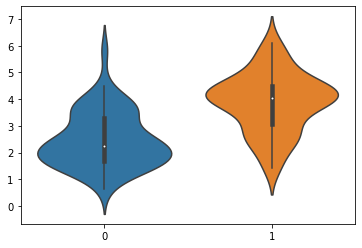

In [15]:
sns.violinplot(data=data)
plt.show()

In [19]:
x_0 = np.concatenate([x1, x2])#.reshape((2*N, 1))
y_0 = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

In [20]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    #theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, start)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 45 seconds.
The acceptance probability does not match the target. It is 0.8816, but should be close to 0.8. Try to increase the number of tuning steps.


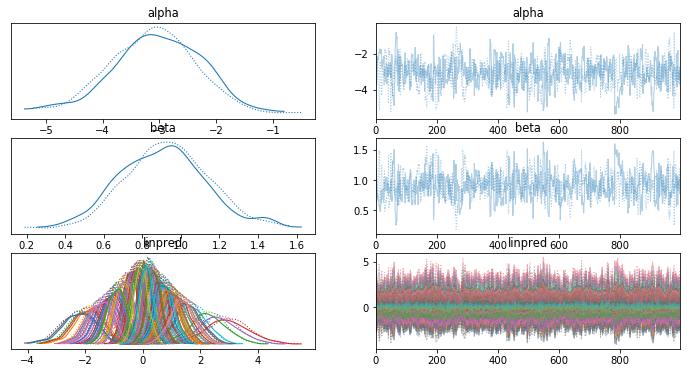

In [13]:
az.plot_trace(fit)
plt.show()

## 2. Binary bivariate classification

In [14]:
data_1 = np.random.normal([2.5,2.5],[1,1], [50,2])
data1_x = data_1[:,0]
data1_y = data_1[:,1]

data_2 = np.random.normal([4,4],[1,1], [50,2])
data2_x = data_2[:,0]
data2_y = data_2[:,1]

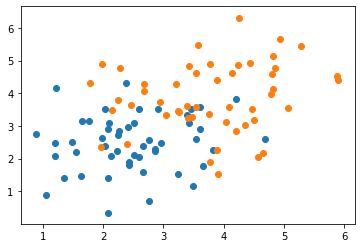

In [15]:
plt.scatter(data1_x, data1_y)
plt.scatter(data2_x, data2_y)
plt.show()

In [3]:
N = 50

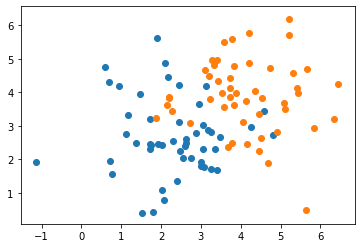

In [16]:
x1 = np.random.normal([2.5,2.5],[1,1], [N,2])
x2 = np.random.normal([4,4],[1,1], [50,2])
plt.scatter(x1[:,0], x1[:,1])
plt.scatter(x2[:,0], x2[:,1])
plt.show()

In [19]:
x_0 = np.concatenate([x1, x2])
y_0 = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

In [20]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations                                                                                                                 
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix                                                                  
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta;                                                                            
}                                                                                                    
model {                                                                                              
  alpha ~ normal(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                   
  for(i in 1:K)                                                                                      
    beta[i] ~ normal(0,10);                                                                 
                                                                                                   
  y ~ bernoulli_logit(linpred);                                                                      
}                                                                                                                                                                                                       
"""  

In [21]:
data = {                                                                                             
    'N': 2*N,                                                                                        
    'K': 2,                                                                                        
    'y': y_0,                                                                                     
    'X': x_0                                                                                             
}  

In [22]:
posterior = stan.build(code, data=data, random_seed=1)


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_ryt1tp_e/model_aezd2xva.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [23]:
fit = posterior.sample(num_chains=2, num_samples=1000)


Sampling:   0%
Sampling:   5% (200/4000)
Sampling:  12% (500/4000)
Sampling:  58% (2300/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!


In [24]:
df = fit.to_frame()  # pandas `DataFrame, requires pandas
print(df.describe().T)

                count       mean        std        min        25%        50%  \
parameters                                                                     
lp__           2000.0 -34.892194   1.276669 -42.890208 -35.454264 -34.546294   
accept_stat__  2000.0   0.928988   0.103082   0.105363   0.902673   0.973683   
stepsize__     2000.0   0.127124   0.008583   0.118543   0.118543   0.127124   
treedepth__    2000.0   3.574000   1.052178   1.000000   3.000000   4.000000   
n_leapfrog__   2000.0  18.999000  11.167289   1.000000  11.000000  15.000000   
...               ...        ...        ...        ...        ...        ...   
linpred.96     2000.0  -1.403770   0.477324  -3.408768  -1.706315  -1.377264   
linpred.97     2000.0   2.240627   0.633925   0.234806   1.806864   2.224094   
linpred.98     2000.0   1.982170   0.490684   0.408603   1.637767   1.965440   
linpred.99     2000.0   1.481373   0.498419  -0.152469   1.148459   1.475718   
linpred.100    2000.0   4.484885   0.866

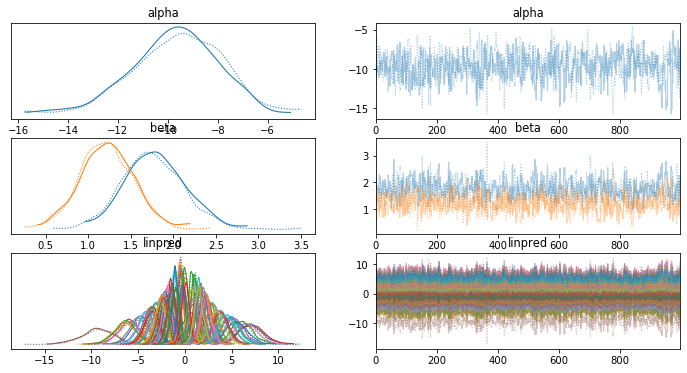

In [25]:
az.plot_trace(fit)
plt.show()